In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
import random
from scipy.io import savemat
import os
from os import path
from sklearn.preprocessing import normalize
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False) #Returns a dictionary with the data
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
import numpy as np
X,y = mnist["data"], mnist["target"]
y = y.astype(int) # Convert y to a list of integers
X = ((X/255.) - .5)*2
print(X.shape, y.shape)
print(min(y), max(y))
print(type(X), type(y))
print(np.min(np.min(X)), np.max(np.max(X)))

(70000, 784) (70000,)
0 9
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
-1.0 1.0


<function matplotlib.pyplot.show(close=None, block=None)>

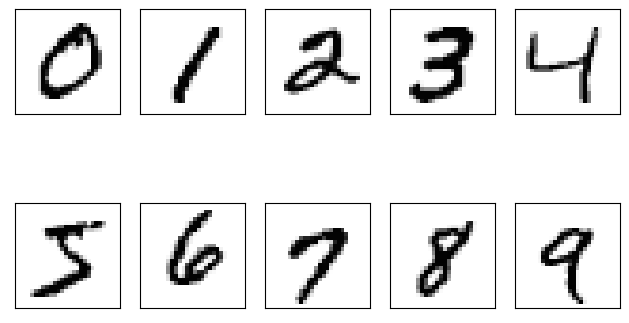

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True)
ax = ax.flatten()
for i in range(10):
    matchlist = [i for i, x in enumerate(y==i) if x]
    img = X[matchlist[0]].reshape(28,28)
    ax[i].imshow(img,cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(60000, 784) (10000, 784) (60000,) (10000,)


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
import collections
split = StratifiedShuffleSplit(n_splits=1,test_size=0.1,random_state=42)
for train_index, val_index in split.split(X_train,y_train):
    X_train_strat = X_train[train_index,:]
    y_train_strat = y_train[train_index]
    
    X_dev_strat = X_train[val_index,:]
    y_dev_strat = y_train[val_index]

print(X_train_strat.shape, y_train_strat.shape, X_dev_strat.shape, y_dev_strat.shape)

(54000, 784) (54000,) (6000, 784) (6000,)


In [8]:
# Define key hyperparameters
class hyperparam:
    num_hid1_units = 300
    num_hid2_units = 100
    num_classes = 10
    input_dim = 28*28
    lr = 0.05 # Learning rate 
    num_epochs = 100 # Number of epochs
    bs = 50 # Mini-batch size
    momentum = 0.9

In [9]:
class myDataset(data.Dataset):
    def __init__(self,input_data,labels):
        # Initialize variables
        self.feats = input_data
        self.labels = labels
        
    def __len__(self):
        return len(self.labels) # returns the number of samples
    
    def __getitem__(self, index):
        X = self.feats[index,:]
        y = self.labels[index]
        
        return X, y
        

In [10]:
params = {'batch_size': hyperparam.bs,
          'shuffle': True,
          'num_workers': 0,
          'drop_last': False,
          'pin_memory': True}

training_set = myDataset(X_train_strat, y_train_strat)
dev_set = myDataset(X_dev_strat, y_dev_strat)
test_set = myDataset(X_test, y_test)

training_gen = data.DataLoader(training_set, **params)
dev_gen = data.DataLoader(dev_set, **params)
testing_gen = data.DataLoader(test_set, **params)


In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.num_hid1_units = hyperparam.num_hid1_units
        self.num_hid2_units = hyperparam.num_hid2_units
        self.num_classes = 10
        self.input_dim = 28 * 28

        # Convolutional layer 1
        self.conv1 = nn.Conv2d(1, 6, 3, stride=1)
        nn.init.xavier_uniform_(self.conv1.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(self.conv1.bias)

        # Convolutional layer 2
        self.conv2 = nn.Conv2d(6, 10, 3, stride=1)
        nn.init.xavier_uniform_(self.conv2.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(self.conv2.bias)

        # Define the size of the input to the fully connected layer
        self.fc_input_size = self.calculate_fc_input_size()

        # Fully connected layer 1
        self.fc1 = nn.Linear(self.fc_input_size, self.num_classes)
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(self.fc1.bias)

    def forward(self, x):
        # Reshape the input
        x = x.view(-1, 1, 28, 28)

        # Convolutional layer 1
        hid1 = func.relu(self.conv1(x))

        # Convolutional layer 2
        hid2 = func.relu(self.conv2(hid1))

        # Flatten the output
        hid2 = hid2.view(-1, self.fc_input_size)

        # Fully connected layer 1
        out = self.fc1(hid2)

        # Apply softmax activation
        out = func.softmax(out, dim=1)

        return out

    def calculate_fc_input_size(self):
        # Function to calculate the input size for the fully connected layer
        # Assuming input image size is 28x28
        conv2_output_size = ((28 - 3) // 1) + 1  # Applying convolution with stride=1 and no padding
        conv2_output_size = ((conv2_output_size - 3) // 1) + 1  # Applying convolution with stride=1 and no padding
        fc_input_size = 10 * conv2_output_size * conv2_output_size
        return fc_input_size

In [12]:
# Create CNN and define loss function
cnn_model = CNN()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=hyperparam.lr, momentum=hyperparam.momentum)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, range(10, 101, 10), gamma=0.9)
loss = nn.CrossEntropyLoss()

In [13]:
best_dev_loss = float('inf')
patience = 10  # Number of epochs to wait for improvement
num_epochs_no_improve = 0
tr_avgLoss_list = []
dev_avgLoss_list = []
tr_accuracy_list = []
dev_accuracy_list = []


# Loop over epochs
for epoch in range(hyperparam.num_epochs):
    print(epoch)
    tr_num_correct = 0
    tr_num_samples = 0
    tr_total_loss = 0.0

    dev_num_correct = 0
    dev_num_samples = 0
    dev_total_loss = 0.0

    # Training
    cnn_model.train(True)
    
    with torch.set_grad_enabled(True):
        
        for local_batch, local_labels in training_gen:
            optimizer.zero_grad()

            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)

            # Model computations
            out1 = cnn_model(local_batch)

            # CrossEntropy loss calculation
            pLoss = loss(out1, local_labels.long())
            tr_total_loss += pLoss*hyperparam.bs
            
            # Backpropagation
            pLoss.backward() # gradient calculation
            optimizer.step() # weight update
            
            sel_class = torch.argmax(out1, dim=1)
            tr_num_correct += sel_class.eq(local_labels).sum().item()
            tr_num_samples += hyperparam.bs
            
        tr_avgLoss = tr_total_loss/len(training_gen.dataset)
        tr_avgLoss_list.append(tr_avgLoss)
        
        tr_accuracy = tr_num_correct/tr_num_samples
        tr_accuracy_list.append(tr_accuracy)

    # Validation
    cnn_model.eval()
    with torch.no_grad():
        for local_batch, local_labels in dev_gen:
            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)

            # Model computations
            out = cnn_model(local_batch)

            # CrossEntropy loss calculation
            pLoss = loss(out, local_labels.long())
            dev_total_loss += pLoss * local_batch.size(0)

            sel_class = torch.argmax(out, dim=1)
            dev_num_correct += sel_class.eq(local_labels).sum().item()
            dev_num_samples += local_batch.size(0)

        dev_avgLoss = dev_total_loss/len(dev_gen.dataset)
        dev_avgLoss_list.append(dev_avgLoss)
        
        dev_accuracy = dev_num_correct/dev_num_samples
        dev_accuracy_list.append(dev_accuracy)

        # Check for early stopping
        if dev_avgLoss < best_dev_loss:
            best_dev_loss = dev_avgLoss
            num_epochs_no_improve = 0
        else:
            num_epochs_no_improve += 1
            if num_epochs_no_improve >= patience:
                print("Early stopping! No improvement for", patience, "epochs.")
                break


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
Early stopping! No improvement for 10 epochs.


In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


# Testing
cnn_model.eval()
with torch.no_grad():
    test_total_loss = 0.0
    test_num_samples = 0
    test_num_correct = 0
    pred = []
    y_testnew = []

    for local_batch, local_labels in testing_gen:
        local_batch = local_batch.float()
        local_labels = local_labels.float()
        local_batch, local_labels = Variable(local_batch), Variable(local_labels)
        # Model computation
        out1 = cnn_model(local_batch)
        pLoss = loss(out1, local_labels.long())
        test_total_loss += pLoss * len(local_labels)  # Correct for average based on batch
        sel_class = torch.argmax(out1, dim=1)
        pred += sel_class.tolist()
        y_testnew += local_labels.tolist()

        test_num_correct += accuracy_score(local_labels, sel_class, normalize=False)
        test_num_samples += len(local_labels)

    test_avgLoss = test_total_loss / len(testing_gen.dataset)
    test_accuracy = test_num_correct / test_num_samples

    print('Test: Loss: {:>.9f}, Test Accuracy: {:>.5f}'.format(test_avgLoss, test_accuracy))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_testnew, pred)
    print("Confusion Matrix:\n", conf_matrix)

Test: Loss: 1.574239016, Test Accuracy: 0.88690
Confusion Matrix:
 [[ 976    0    2    1    0    0    0    1    0    0]
 [   0 1126    4    2    0    0    3    0    0    0]
 [   4    3 1018    1    1    0    1    4    0    0]
 [   3    0    9  991    0    0    0    6    1    0]
 [   1    2    1    1  960    0    0    1    1   15]
 [  32   11    2  452    2    0   73    5  151  164]
 [  24    3    4    1    5    0  921    0    0    0]
 [   0    4   17    4    0    0    0  998    0    5]
 [  22    3   16    4    2    0   10    6  902    9]
 [   7    7    2    2    7    0    0    7    0  977]]


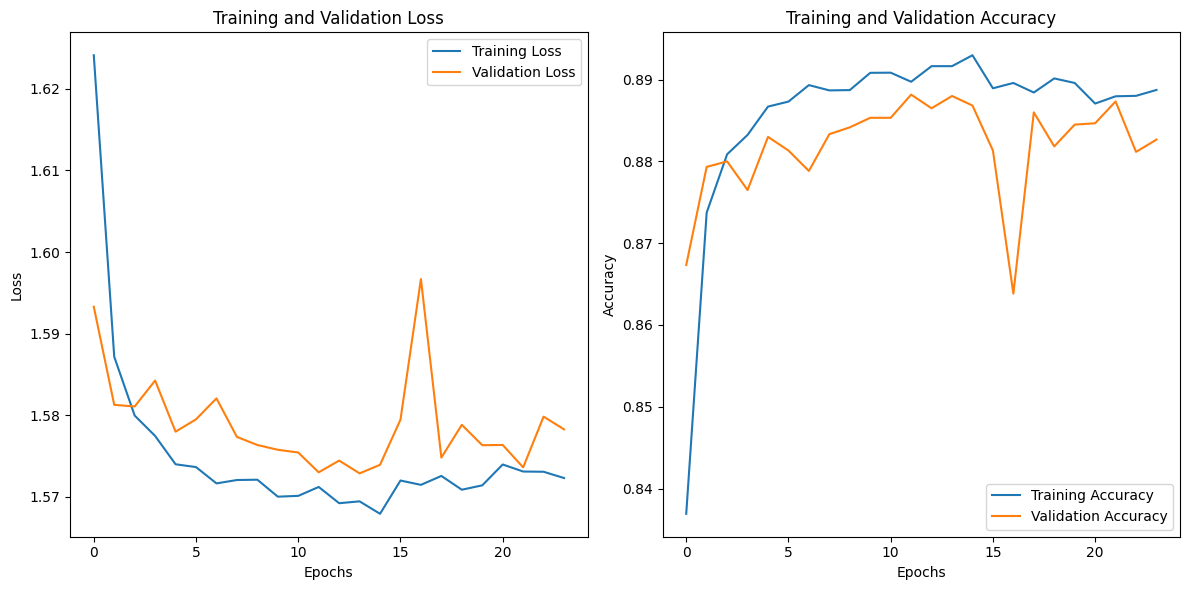

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Convert PyTorch tensors to NumPy arrays
tr_avgLoss_np = [loss.detach().numpy() for loss in tr_avgLoss_list]
dev_avgLoss_np = [loss.detach().numpy() for loss in dev_avgLoss_list]

# Plot learning curves
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(len(tr_avgLoss_np)), tr_avgLoss_np, label='Training Loss')
plt.plot(range(len(dev_avgLoss_np)), dev_avgLoss_np, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(tr_accuracy_list)), tr_accuracy_list, label='Training Accuracy')
plt.plot(range(len(dev_accuracy_list)), dev_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [1]:
#The validation loss mostly decreases and the validation accuracy most increases as the epoches increase. Thus, I would say that the model is not overfitting nor underfitting the data and is reasonably fitting the data.